# Summary of "Data-Driven Traffic Forecasting and Control" Project

#### Author: Gururaj H C
#### Date: 2025-05-30

This project implements an end-to-end pipeline for analyzing and forecasting traffic volume using the Metro Interstate Traffic Volume dataset, culminating in a prototype Reinforcement Learning (RL) agent for traffic light control. The work demonstrates expertise in time-series analysis, deep learning, and RL methodologies, directly aligning with the SMART-ROUTE project's research themes.

---

## Key Stages and Findings

### 1. Data Preprocessing & Exploratory Data Analysis (EDA)
- **Dataset**:  
  - Cleaned and resampled to hourly frequency (2016–2018)  
  - Imputed missing values and standardized exogenous variables (temperature, rainfall)

- **Seasonality & Trends**:  
  - STL decomposition revealed:  
    - **Daily**: Bimodal peaks (commuter rush hours)  
    - **Weekly**: Weekend dips  
  - Hourly/day-of-week averages confirmed commuter patterns  

- **Correlation Analysis**:  
  - Weak linear relationships:  
    - Traffic volume vs. temperature: `0.12`  
    - Traffic volume vs. rainfall: `0.007`  
  - Suggested need for non-linear modeling or additional weather features  

- **Distribution Insights**:  
  - Visualized traffic volume characteristics   

---

### 2. Univariate Forecasting Baselines 
- **Models**:  
  - LSTM (one-step ahead)  
  - ARIMA(2,1,2)  

- **Results**:  
  - LSTM significantly outperformed ARIMA:  
    - **MAE**: `215.0` (LSTM) vs. `2791.9` (ARIMA)  
  - Highlighted deep learning's superiority for this complex time series  

---

### 3. Multi-Step & Multivariate Forecasting 
- **Model**: Direct multi-step LSTM forecasting 24-hour horizon  
  - Inputs: Traffic volume, temperature, rainfall  

- **Performance**:  
  - **MAE**: Averaged `282.1` across 24-hour window  
  - Error increased with forecast horizon 

- **Feature Ablation Study**:  
  - Removing temperature increased MAE to `374.2`  
  - Removing rainfall increased MAE to `355.5`  
  - **Conclusion**: Temperature > Rainfall as a predictive feature  

- **Error Diagnostics**:  
  - MAE heatmap revealed:  
    - Higher errors during peak hours  
    - Degraded performance for longer horizons  

---

### 4. RL Traffic-Light Control Prototype 
- **Environment**:  
  - Custom two-phase (NS/EW) traffic light in Gymnasium  
  - State: Queue lengths | Actions: Phase selection  
  - Reward: Penalized total queue length  

- **Agent**:  
  - DQN (Stable-Baselines3) trained for `10,000` timesteps  

- **Results**:  
  - Cumulative reward plot showed improving policy over `500` steps  
  - Demonstrated ability to reduce simulated queue lengths  

## Conclusions & Alignment

- **Key findings**: This project successfully demonstrated an end-to-end pipeline for traffic volume forecasting, with LSTM models outperforming ARIMA baselines for one-step prediction (MAE 215.0 vs 2791.9). The multivariate, multi-step LSTM provided 24-hour forecasts (overall MAE 282.1), and feature ablation highlighted the impact of exogenous variables like temperature. Error diagnostics, such as the MAE heatmap, revealed patterns in forecast accuracy across different times and horizons. Furthermore, a prototype DQN agent for traffic light control showed promising learning capabilities in a simulated environment, reducing queue lengths.

- **PhD Research Alignment**:
  - The application of **Deep Learning (LSTMs) for Time-Series Analysis** of traffic network states directly aligns with the data-driven approaches sought for **PhD Position 1**. The EDA and forecasting components contribute to understanding and calculating dynamic network states.
  - The development of a **Reinforcement Learning (DQN) agent** in a **simulated** traffic environment to **optimize** control strategies strongly resonates with **PhD Position 2**, particularly its focus on AI for optimizing and controlling multi-agent systems in transportation.
  - The methodologies explored, from advanced forecasting to RL, provide a strong foundation for research in both Applied Mathematics (e.g., optimization in RL) and AI (e.g., hybrid modeling) within the SMART-ROUTE project.

- **Future directions**: Future work could involve incorporating **Graph Neural Networks (GNNs)** to model spatial dependencies in traffic networks, further enhancing the realism and predictive power of the models. Integrating more complex RL algorithms and realistic traffic simulators (like SUMO) would also be valuable extensions.

- **Reproducibility archive**: The code, data, and configurations are structured to ensure reproducibility and could be packaged for deployment or further research.

## 1. Configuration & Imports

In [1]:
"""
Summary:
- Define file_path variable for modularity.
- Import all libraries used across sections.
"""

# Path to data file
file_path = r'C:\Users\Maverick\Downloads\metro+interstate+traffic+volume\Metro_Interstate_Traffic_Volume._Dataset\Metro_Interstate_Traffic_Volume.csv'

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time-series and modeling
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, LSTM, Dense, RepeatVector,
                                     TimeDistributed, Attention, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping

# RL
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN

# Plot settings
sns.set(style='whitegrid')

## 2. Data Loading & Cleaning

In [2]:
"""
Summary:
- Load CSV from `file_path` variable.
- Convert to datetime index, drop duplicates.
- Restrict to continuous period (2016–2018) to handle inherent gap.
"""

df = pd.read_csv(file_path, parse_dates=['date_time'], index_col='date_time')
# Remove duplicate timestamps
df = df[~df.index.duplicated(keep='first')]
# Select continuous span
start_date, end_date = '2016-01-01', '2018-12-31'
df = df.loc[start_date:end_date].sort_index()
# Resample to hourly on numeric columns and forward-fill missing hours
df_hour = df.resample('h').mean(numeric_only=True).ffill()

# Check gaps
gaps = df_hour.index.to_series().diff().gt('1H').sum()
print(f"Hourly gaps after cleaning: {gaps}")

# Preview
df_hour.head()

Hourly gaps after cleaning: 0


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2016-01-01 00:00:00,265.94,0.0,0.0,90.0,1513.0
2016-01-01 01:00:00,266.00,0.0,0.0,90.0,1550.0
2016-01-01 02:00:00,266.00,0.0,0.0,90.0,1550.0
2016-01-01 03:00:00,266.01,0.0,0.0,90.0,719.0
2016-01-01 04:00:00,264.80,0.0,0.0,90.0,533.0


## 3. Exploratory Data Analysis (EDA)

### 📦 Block 3.1: STL Decomposition of Traffic Volume

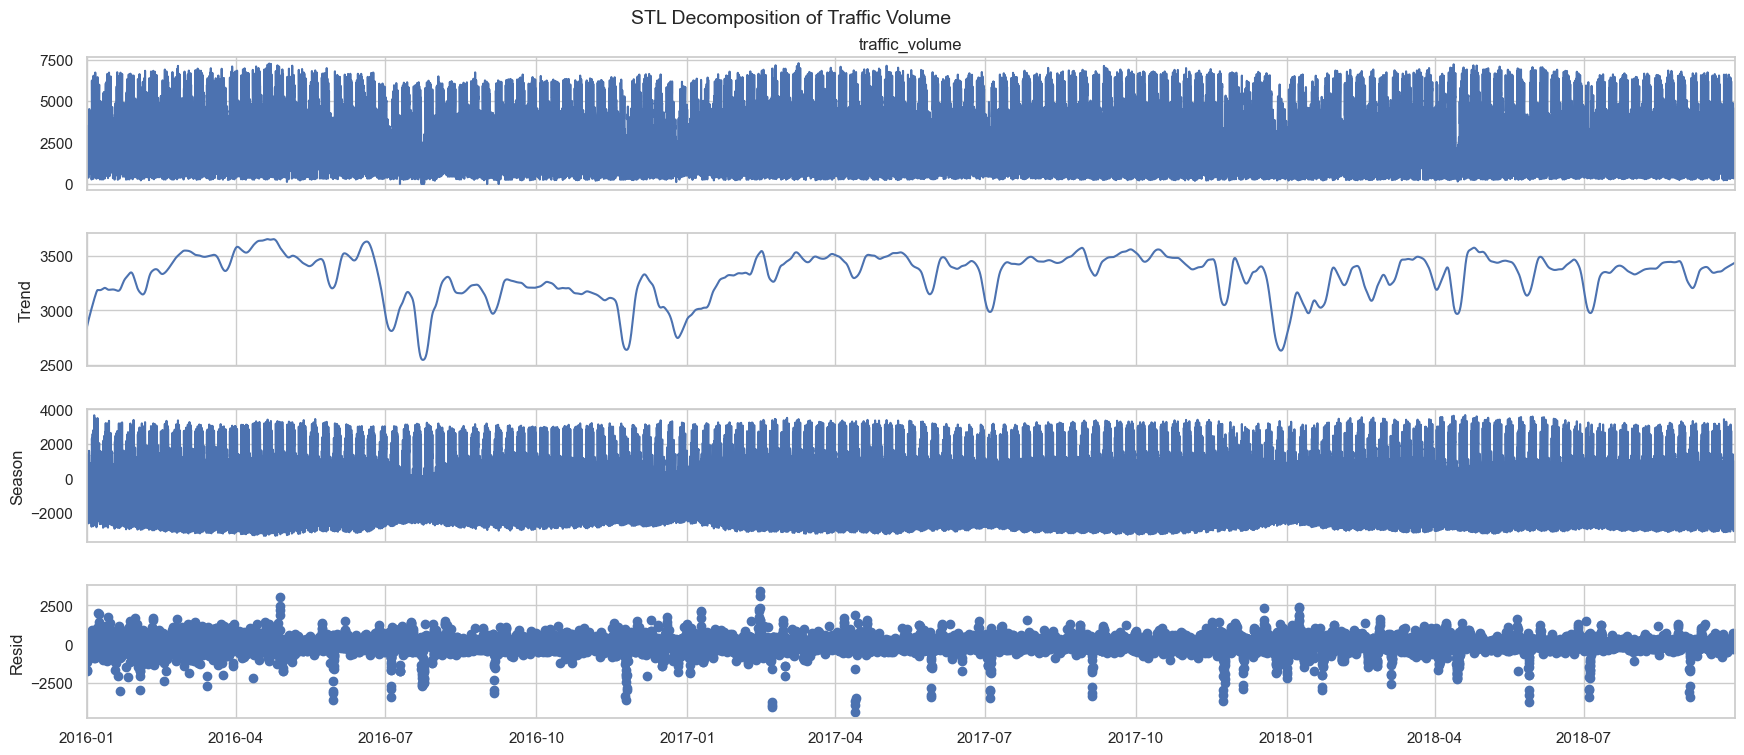

In [3]:
"""
STL decomposition to separate trend, seasonality, residuals.
"""
from statsmodels.tsa.seasonal import STL

stl = STL(df_hour['traffic_volume'], period=24*7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 8)
fig.suptitle("STL Decomposition of Traffic Volume", fontsize=14)
plt.show()

### 📦 Block 3.2: Daily Profile of Traffic Volume

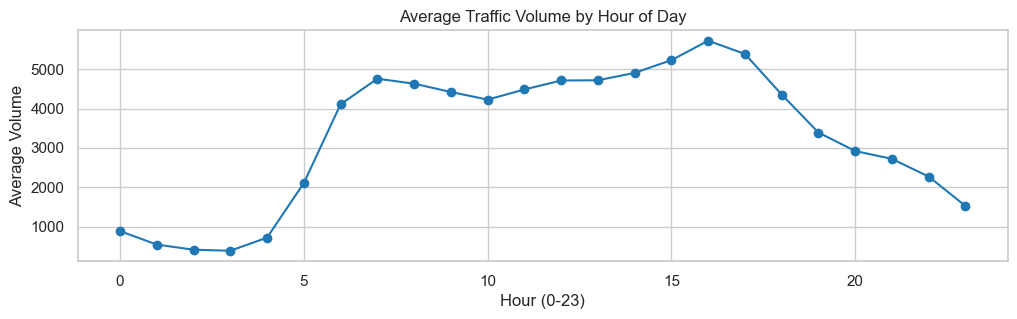

In [4]:
"""
Daily (hourly) traffic pattern.
"""
hourly = df_hour['traffic_volume'].groupby(df_hour.index.hour).mean()
plt.figure(figsize=(12,3))
plt.plot(hourly.index, hourly.values, '-o', color='tab:blue')
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Average Volume")
plt.grid(True)
plt.show()

### 📦 Block 3.3: Weekly Profile of Traffic Volume

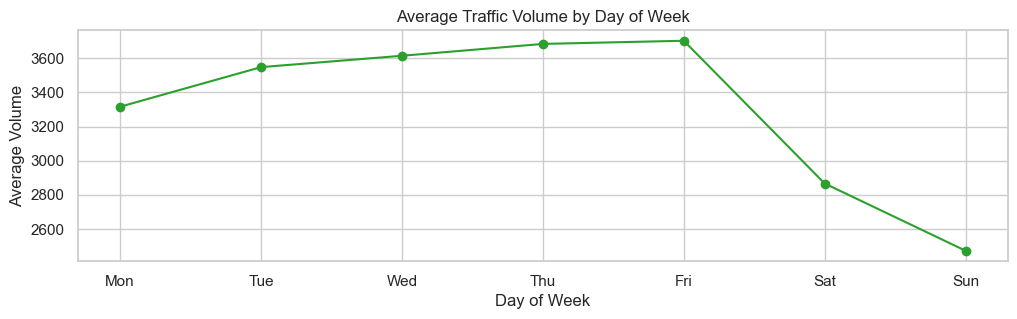

In [5]:
"""
Weekly (day-of-week) traffic pattern.
"""
dow = df_hour['traffic_volume'].groupby(df_hour.index.dayofweek).mean()
plt.figure(figsize=(12,3))
plt.plot(dow.index, dow.values, '-o', color='tab:green')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Average Traffic Volume by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Volume")
plt.grid(True)
plt.show()

### 📦 Block 3.4: Correlation with Weather Features

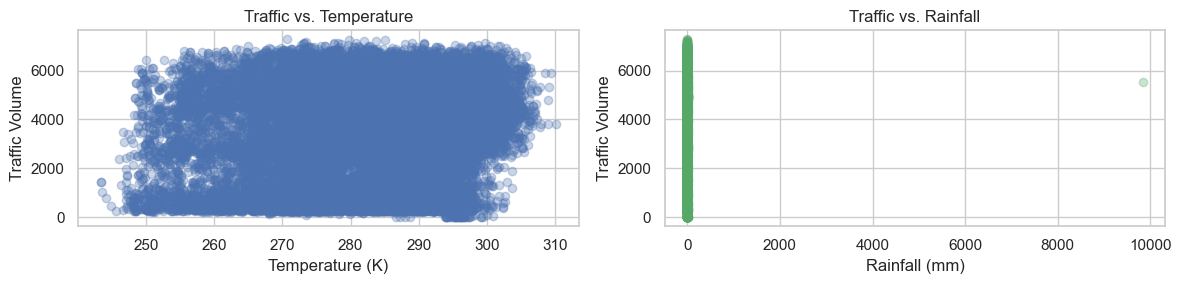

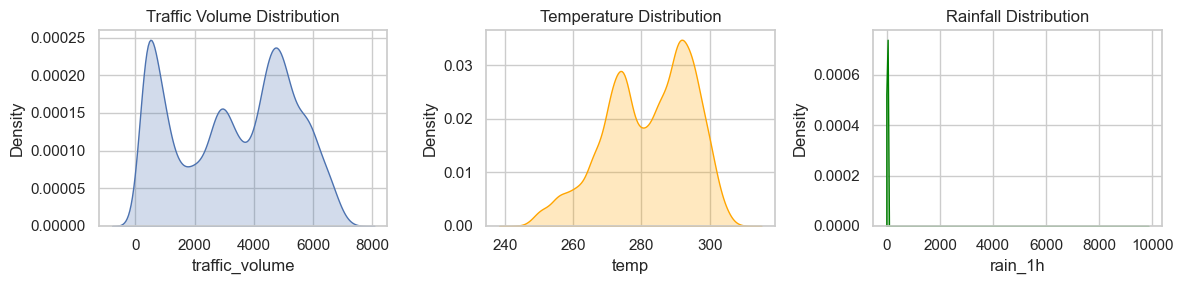

Correlation with Traffic Volume:
traffic_volume    1.000000
temp              0.123619
rain_1h           0.007163
Name: traffic_volume, dtype: float64


In [6]:
"""
Summary:
- Plot clear, separate scatter plots for Traffic vs. Temp and Traffic vs. Rain_1h.
- Add individual KDE plots for distribution analysis.
- Allow flexible figure sizing via figsize parameter.
"""

# Set your desired figure size here:
scatter_figsize = (12, 3)
kde_figsize = (12, 3)

# Scatter Plots: Traffic vs. Weather
fig, ax = plt.subplots(1, 2, figsize=scatter_figsize)
ax[0].scatter(df_hour['temp'], df_hour['traffic_volume'], alpha=0.3)
ax[0].set_title('Traffic vs. Temperature')
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('Traffic Volume')

ax[1].scatter(df_hour['rain_1h'], df_hour['traffic_volume'], alpha=0.3, color='g')
ax[1].set_title('Traffic vs. Rainfall')
ax[1].set_xlabel('Rainfall (mm)')
ax[1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

# KDE Plots for Distributions
fig, ax = plt.subplots(1, 3, figsize=kde_figsize)
sns.kdeplot(df_hour['traffic_volume'], ax=ax[0], fill=True)
ax[0].set_title('Traffic Volume Distribution')

sns.kdeplot(df_hour['temp'], ax=ax[1], fill=True, color='orange')
ax[1].set_title('Temperature Distribution')

sns.kdeplot(df_hour['rain_1h'], ax=ax[2], fill=True, color='green')
ax[2].set_title('Rainfall Distribution')

plt.tight_layout()
plt.show()

# Correlation Table
corr = df_hour[['traffic_volume', 'temp', 'rain_1h']].corr().loc['traffic_volume', :]
print('Correlation with Traffic Volume:')
print(corr)


### 📦 Block 3.5: Distribution of Traffic Volume

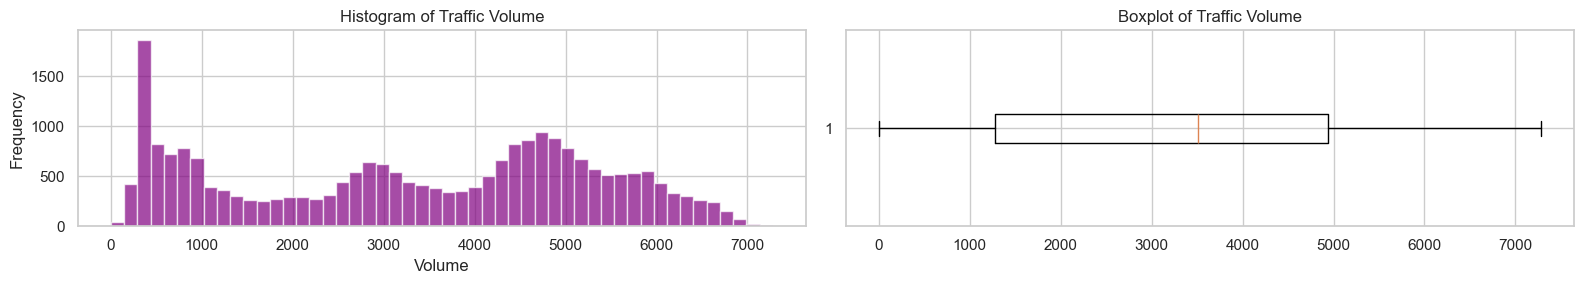

In [7]:
"""
Histogram and boxplot of traffic volume.
"""
fig, ax = plt.subplots(1,2,figsize=(16,3))
ax[0].hist(df_hour['traffic_volume'], bins=50, color='purple', alpha=0.7)
ax[0].set_title("Histogram of Traffic Volume")
ax[0].set_xlabel("Volume"); ax[0].set_ylabel("Frequency")
ax[1].boxplot(df_hour['traffic_volume'], vert=False)
ax[1].set_title("Boxplot of Traffic Volume")
plt.tight_layout()
plt.show()


## Block 3.6: long-term temporal patterns

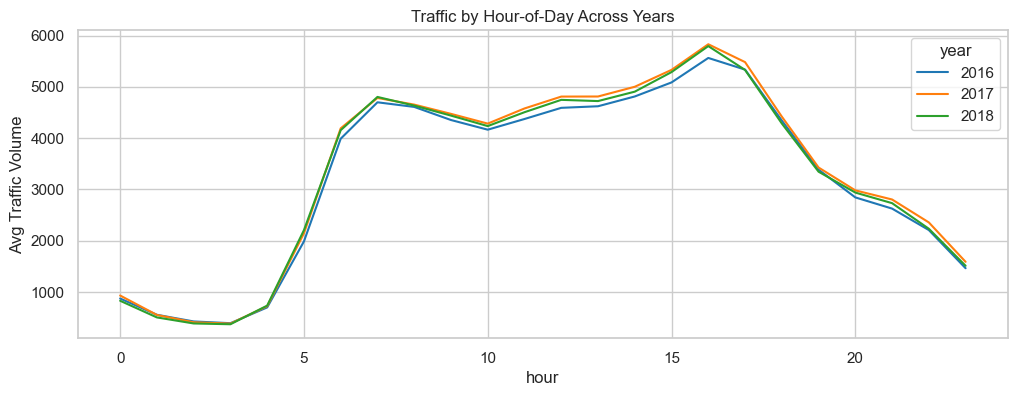

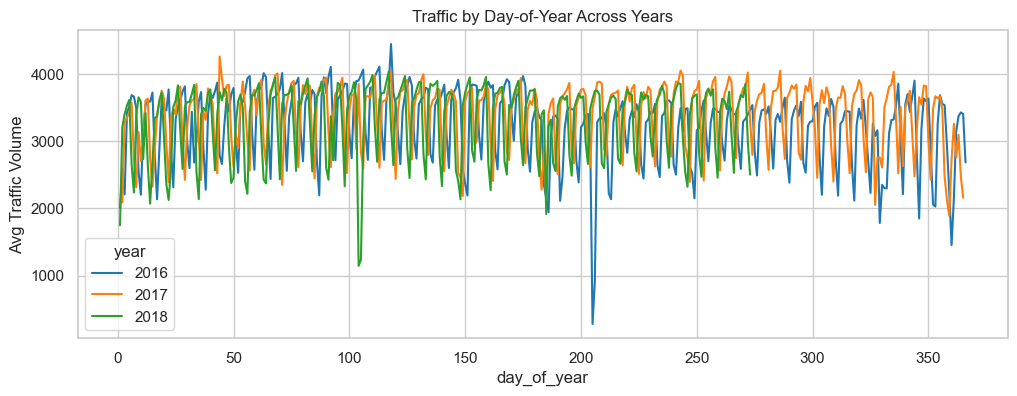

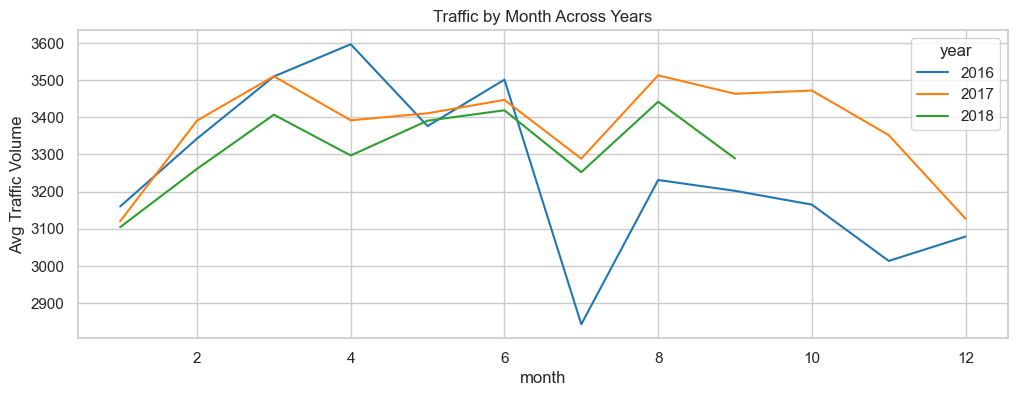

In [8]:
"""
Compare traffic patterns:
- Same hour across years
- Same day across years
- Same month across years
"""

# 1️⃣ Hour-of-Day Comparison by Year
df_hour['year'] = df_hour.index.year
df_hour['hour'] = df_hour.index.hour
hourly_avg = df_hour.groupby(['year', 'hour'])['traffic_volume'].mean().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(data=hourly_avg, x='hour', y='traffic_volume', hue='year', palette='tab10')
plt.title('Traffic by Hour-of-Day Across Years')
plt.ylabel('Avg Traffic Volume')
plt.show()

# 2️⃣ Day-of-Year Comparison
df_hour['day_of_year'] = df_hour.index.dayofyear
daily_avg = df_hour.groupby(['year', 'day_of_year'])['traffic_volume'].mean().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(data=daily_avg, x='day_of_year', y='traffic_volume', hue='year', palette='tab10')
plt.title('Traffic by Day-of-Year Across Years')
plt.ylabel('Avg Traffic Volume')
plt.show()

# 3️⃣ Month Comparison
df_hour['month'] = df_hour.index.month
monthly_avg = df_hour.groupby(['year', 'month'])['traffic_volume'].mean().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(data=monthly_avg, x='month', y='traffic_volume', hue='year', palette='tab10')
plt.title('Traffic by Month Across Years')
plt.ylabel('Avg Traffic Volume')
plt.show()

## 📌 4. Univariate Forecasting Baselines

In [9]:
"""
Summary:
- One-step LSTM forecast.
- ARIMA(2,1,2) comparison.
- Report MAE, MSE metrics.
"""

# Prepare data
vol = df_hour['traffic_volume']
scaler = MinMaxScaler()
vol_s = scaler.fit_transform(vol.values.reshape(-1,1))

def make_uni_windows(arr, ws=24):
    X,y=[],[]
    for i in range(len(arr)-ws): X.append(arr[i:i+ws]); y.append(arr[i+ws])
    return np.array(X), np.array(y)

X,y = make_uni_windows(vol_s)
X = X.reshape(-1,24,1)
split=-24*7
X_tr, X_te, y_tr, y_te = X[:split], X[split:], y[:split], y[split:]

# LSTM Model
tf.random.set_seed(0)
model_lstm = Sequential([Input((24,1)), LSTM(32), Dense(1)])
model_lstm.compile('adam','mse')
model_lstm.fit(X_tr,y_tr,epochs=20,validation_split=0.2,verbose=1)

y_pred = model_lstm.predict(X_te)
true_lstm = scaler.inverse_transform(y_te.reshape(-1,1))
pred_lstm = scaler.inverse_transform(y_pred)

# ARIMA
arima_res = ARIMA(vol.values[:split+24], order=(2,1,2)).fit()
arima_fc = arima_res.forecast(steps=168)

# Metrics
print('LSTM MAE:', mean_absolute_error(true_lstm, pred_lstm))
print('ARIMA MAE:', mean_absolute_error(vol.values[-168:], arima_fc))

Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0437 - val_loss: 0.0084
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 4/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 6/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 8/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 9/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 10/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 11/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 12/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

## 📌 5. Multi-Step Forecasting

X shape: (24048, 24, 3), y shape: (24048, 24)
Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0937 - val_loss: 0.0198
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0198 - val_loss: 0.0167
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0175 - val_loss: 0.0155
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0153 - val_loss: 0.0135
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0142 - val_loss: 0.0125
Epoch 9/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 10/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0129 - val_loss: 0.0108
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


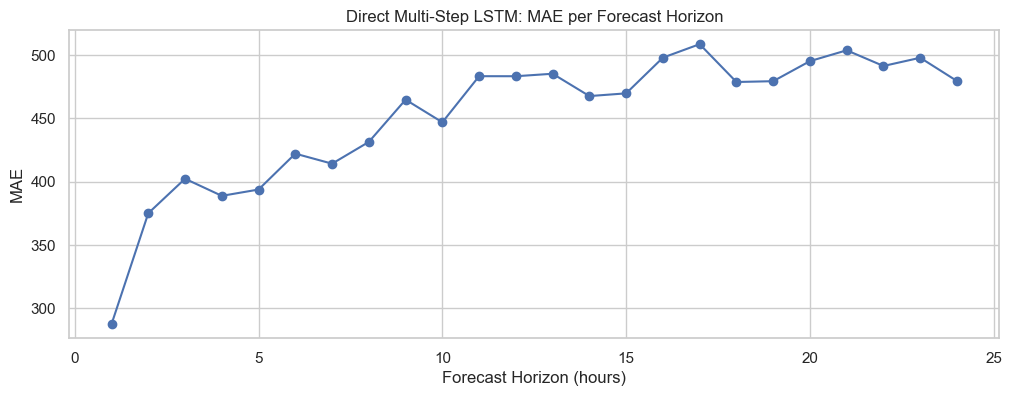

In [10]:
"""
Summary:
- Implements a direct multi-step forecasting approach with LSTM.
- Forecasts next 24 hours directly in one model output.
- Scales data, prepares windowed data, trains the model, and evaluates MAE per horizon.
"""

# --- Data Preparation ---
horizon = 24  # Forecast horizon in hours
features = ['traffic_volume', 'temp', 'rain_1h']  # Use as needed

# Scale all features
scaler_multi = MinMaxScaler()
scaled = scaler_multi.fit_transform(df_hour[features])

# Create windows: [past 24 -> next 24]
X_multi, y_multi = [], []
window = 24
for i in range(len(scaled) - window - horizon):
    X_multi.append(scaled[i:i+window])
    y_multi.append(scaled[i+window:i+window+horizon, 0])  # traffic_volume only

X_multi, y_multi = np.array(X_multi), np.array(y_multi)
print(f"X shape: {X_multi.shape}, y shape: {y_multi.shape}")

# Train-test split: last 7 days for test
split = -24*7
X_train, X_test = X_multi[:split], X_multi[split:]
y_train, y_test = y_multi[:split], y_multi[split:]

# --- LSTM Model ---
tf.random.set_seed(42)
direct_model = Sequential([
    Input(shape=(window, X_multi.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(horizon)
])
direct_model.compile(optimizer='adam', loss='mse')
history = direct_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# --- Evaluation ---
y_pred_direct = direct_model.predict(X_test)

# Inverse transform predictions and ground truth
y_pred_direct_full = np.zeros((y_pred_direct.shape[0], y_pred_direct.shape[1], scaled.shape[1]))
y_pred_direct_full[:,:,0] = y_pred_direct  # only traffic_volume predictions
y_pred_direct_inv = scaler_multi.inverse_transform(y_pred_direct_full.reshape(-1, scaled.shape[1]))[:,0].reshape(y_pred_direct.shape)

y_test_full = np.zeros((y_test.shape[0], y_test.shape[1], scaled.shape[1]))
y_test_full[:,:,0] = y_test
y_test_inv = scaler_multi.inverse_transform(y_test_full.reshape(-1, scaled.shape[1]))[:,0].reshape(y_test.shape)

# --- MAE per horizon ---
mae_direct = np.mean(np.abs(y_pred_direct_inv - y_test_inv), axis=0)

# --- Plot ---
plt.figure(figsize=(12,4))
plt.plot(range(1, horizon+1), mae_direct, marker='o')
plt.title('Direct Multi-Step LSTM: MAE per Forecast Horizon')
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

Epoch 1/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0657 - val_loss: 0.0179
Epoch 2/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0183 - val_loss: 0.0154
Epoch 3/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0165 - val_loss: 0.0142
Epoch 4/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0155 - val_loss: 0.0132
Epoch 5/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0146 - val_loss: 0.0123
Epoch 6/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0137 - val_loss: 0.0111
Epoch 7/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0127 - val_loss: 0.0104
Epoch 8/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 9/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0112 - val_loss: 0.0089
Epoch 10/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 11/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 12/50
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

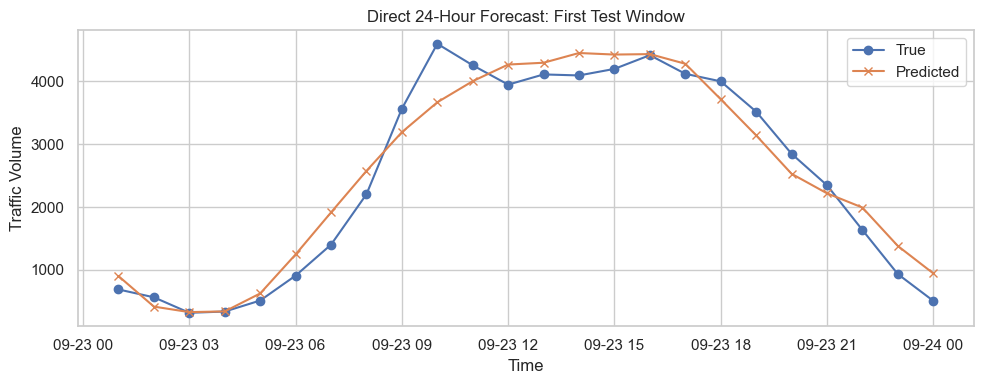


Overall direct-forecast MAE (averaged over all windows & horizons): 285.5


In [11]:
"""
Summary:
- Implements a multi-step direct forecasting approach using LSTM for 24-hour traffic volume prediction.
- Uses 24-hour input windows to predict the next 24 hours directly in a single model output.
- Scales data with MinMaxScaler, prepares sequential windows, and splits into training/testing sets.
- Builds and trains an LSTM model with EarlyStopping.
- Inverse-transforms predictions and computes per-horizon MAE across 24-hour forecasts.
- Plots the first test window’s 24-hour forecast vs. true values and prints average MAE across all test windows.
"""

# ----------------------------
# MULTI-STEP DIRECT FORECASTING (24-hour horizon)
# ----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1) LOAD & PREP DATA (reuse df_hour from before)

series = df_hour['traffic_volume'].values.reshape(-1, 1)
timestamps = df_hour.index

# 2) SCALE
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# 3) BUILD MULTI-STEP WINDOWS
WIN_IN, WIN_OUT = 24, 24
X_ms, y_ms = [], []
for i in range(len(series_scaled) - WIN_IN - WIN_OUT + 1):
    X_ms.append(series_scaled[i : i + WIN_IN])
    y_ms.append(series_scaled[i + WIN_IN : i + WIN_IN + WIN_OUT].flatten())
X_ms = np.array(X_ms)              # shape (N, 24, 1)
y_ms = np.array(y_ms)              # shape (N, 24)

# 4) SPLIT train/test (last 7 days of windows as test)
n_test = 24 * 7
split_idx = len(X_ms) - n_test
X_train, y_train = X_ms[:split_idx], y_ms[:split_idx]
X_test,  y_test  = X_ms[split_idx:], y_ms[split_idx:]

# 5) BUILD & TRAIN DIRECT-FORECAST LSTM
model_ms = Sequential([
    Input(shape=(WIN_IN, 1)),
    LSTM(64, return_sequences=False),
    Dense(WIN_OUT)
])
model_ms.compile(optimizer='adam', loss='mse')
es_ms = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ms = model_ms.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es_ms],
    verbose=1
)

# 6) PREDICT & INVERT SCALE
y_pred_ms = model_ms.predict(X_test)           # (n_test, 24)

# invert each horizon separately
y_test_inv = scaler.inverse_transform(y_test.flatten()[:,None]).reshape(-1, WIN_OUT)
y_pred_inv = scaler.inverse_transform(y_pred_ms.flatten()[:,None]).reshape(-1, WIN_OUT)

# 7) PER-HORIZON METRICS
horizon_mae = [mean_absolute_error(y_test_inv[:,h], y_pred_inv[:,h]) for h in range(WIN_OUT)]
print("MAE by horizon (hours ahead 1→24):")
print(np.round(horizon_mae, 1))

# 8) PLOT example: first test window vs. its 24-hr forecast
start_ts = timestamps[ split_idx + WIN_IN ]
example_idx = pd.date_range(start=start_ts, periods=WIN_OUT, freq='h')

plt.figure(figsize=(10,4))
plt.plot(example_idx, y_test_inv[0], marker='o', label='True')
plt.plot(example_idx, y_pred_inv[0], marker='x', label='Predicted')
plt.title('Direct 24-Hour Forecast: First Test Window')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

# 9) AVERAGE MAE OVER ALL HOURS
print(f"\nOverall direct-forecast MAE (averaged over all windows & horizons): "
      f"{np.mean(np.abs(y_test_inv - y_pred_inv)):.1f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


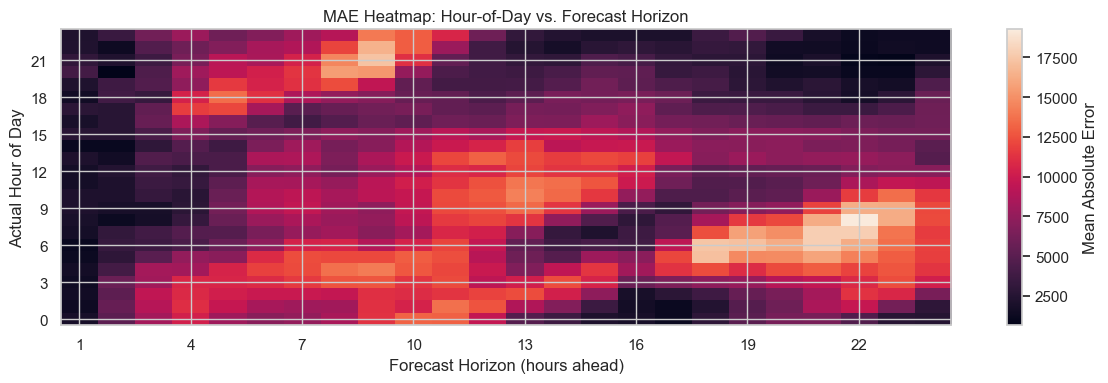

In [12]:
"""
Summary:
- Analyzes multi-step LSTM forecast errors across different hours of the day and forecast horizons.
- Rebuilds the dataset, rescales data, and prepares sliding windows for the last test week.
- Predicts using the previously trained multi-step model, inverses scaling, and computes per-horizon errors.
- Aggregates MAE values into a DataFrame by actual hour of day and forecast horizon.
- Plots a heatmap of MAE to visualize how forecast accuracy varies across time and prediction steps.
"""

# ----------------------------
# ERROR ANALYSIS: HEATMAP OF MAE BY HOUR-OF-DAY & HORIZON
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# 1) REBUILD df_hour & scaler (if not in memory)
df = pd.read_csv(file_path,
                 parse_dates=['date_time'],
                 index_col='date_time')
df_hour = df['traffic_volume'].resample('h').sum().to_frame()

scaler = MinMaxScaler()
scaler.fit(df_hour[['traffic_volume']])

# 2) PARAMETERS
WIN_IN, WIN_OUT = 24, 24
n_test = 24 * 7  # last week

# 3) BUILD WINDOWS & COLLECT TIMESTAMPS
series_scaled = scaler.transform(df_hour[['traffic_volume']].values)
X, y, ts = [], [], []
for i in range(len(series_scaled) - WIN_IN - WIN_OUT + 1):
    X.append(series_scaled[i : i + WIN_IN])
    y.append(series_scaled[i + WIN_IN : i + WIN_IN + WIN_OUT])
    ts.append(df_hour.index[i + WIN_IN : i + WIN_IN + WIN_OUT])
X = np.array(X)
y = np.array(y)  # (N,24,1)

# 4) SPLIT OUT THE TEST WEEK
X_test = X[-n_test:]
y_test = y[-n_test:]
ts_test = ts[-n_test:]  # list of DatetimeIndex for each window

# 5) PREDICT & INVERT
#    ensure model_ms is defined (your multi-step LSTM)
y_pred = model_ms.predict(X_test).reshape(-1,1)
y_true = y_test.reshape(-1,1)
y_pred_inv = scaler.inverse_transform(y_pred).reshape(-1, WIN_OUT)
y_true_inv = scaler.inverse_transform(y_true).reshape(-1, WIN_OUT)

# 6) AGGREGATE ERRORS INTO A DATAFRAME
records = []
for w in range(n_test):
    for h in range(WIN_OUT):
        records.append({
            'timestamp': ts_test[w][h],
            'horizon': h + 1,
            'error': abs(y_true_inv[w,h] - y_pred_inv[w,h])
        })
df_err = pd.DataFrame(records)
df_err['hour'] = df_err['timestamp'].dt.hour

# 7) PIVOT TO HEATMAP MATRIX
heatmat = df_err.pivot_table(
    index='hour', columns='horizon', values='error', aggfunc='mean'
)

# 8) PLOT
plt.figure(figsize=(12,4))
im = plt.imshow(heatmat, aspect='auto', origin='lower')
plt.colorbar(im, label='Mean Absolute Error')
plt.xlabel('Forecast Horizon (hours ahead)')
plt.ylabel('Actual Hour of Day')
plt.title('MAE Heatmap: Hour-of-Day vs. Forecast Horizon')
plt.xticks(np.arange(WIN_OUT), np.arange(1, WIN_OUT+1))
plt.yticks(np.arange(24), np.arange(0,24))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## 📌 7. Multivariate Modeling & Ablation

Epoch 1/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0400 - val_loss: 0.0159
Epoch 2/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0175 - val_loss: 0.0146
Epoch 3/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0162 - val_loss: 0.0130
Epoch 4/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0150 - val_loss: 0.0117
Epoch 5/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 6/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 7/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 8/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0122 - val_loss: 0.0083
Epoch 9/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0118 - val_loss: 0.0079
Epoch 10/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 11/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 12/50
1309/13

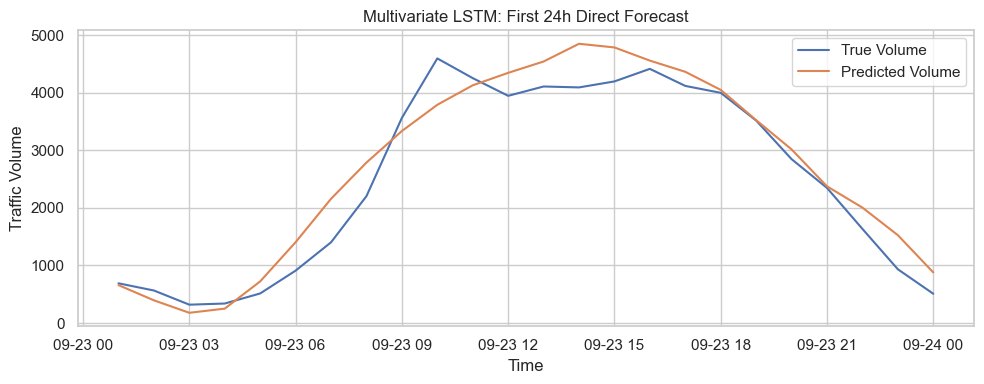

In [13]:
"""
Summary:
- Builds a multivariate LSTM model for 24-hour ahead traffic volume forecasting using past 24-hour windowed data.
- Input features include traffic volume, temperature, and rainfall.
- Data is resampled hourly, scaled, and structured into supervised learning format (24-hour input → 24-hour output).
- Trains an LSTM model to directly predict the next 24 hours of traffic volume.
- Inverts scaling for only the traffic volume column after prediction.
- Computes overall Mean Absolute Error (MAE) for test data and visualizes the first forecast window.
"""
# ----------------------------
# MULTIVARIATE DIRECT FORECAST (24-hour horizon)
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1) LOAD & PREP DATA
df = pd.read_csv(file_path,
    parse_dates=['date_time'],
    index_col='date_time'
)

# Select your features: 
features = ['traffic_volume', 'temp', 'rain_1h']
df_sel = df[features].resample('h').mean().ffill()

# 2) SCALE all features together
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_sel.values)   # shape (T, 3)

# 3) BUILD WINDOWS: 24-in → 24-out (only traffic volume as target)
WIN_IN, WIN_OUT = 24, 24
X_mv, y_mv = [], []
for i in range(len(data_scaled) - WIN_IN - WIN_OUT + 1):
    X_mv.append(data_scaled[i : i + WIN_IN])                          # (24,3)
    y_mv.append(data_scaled[i + WIN_IN : i + WIN_IN + WIN_OUT, 0])    # only volume
X_mv = np.array(X_mv)            # (N, 24, 3)
y_mv = np.array(y_mv)            # (N, 24)

# 4) SPLIT train/test
n_test = 24 * 7
split = len(X_mv) - n_test
X_train, y_train = X_mv[:split], y_mv[:split]
X_test,  y_test  = X_mv[split:], y_mv[split:]

# 5) DEFINE & TRAIN MULTIVARIATE LSTM
model_mv = Sequential([
    Input(shape=(WIN_IN, len(features))),
    LSTM(64, return_sequences=False),
    Dense(WIN_OUT)
])
model_mv.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_mv = model_mv.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# 6) PREDICT & INVERT SCALE
y_pred_mv = model_mv.predict(X_test)    # (n_test, 24)

# We need to invert only the volume column.  
# To do that, we’ll reconstruct a dummy full feature vector:
def invert_volume(scaled_vals):
    # scaled_vals: shape (n,1) for volume
    # pad with zeros for other features (they won’t affect inverse of first dim)
    pad = np.zeros((len(scaled_vals), len(features)-1))
    full = np.hstack([scaled_vals, pad])
    inv = scaler.inverse_transform(full)[:,0]
    return inv

# Flatten and invert
y_test_flat = y_test.flatten()[:,None]
y_pred_flat = y_pred_mv.flatten()[:,None]
y_true_inv = invert_volume(y_test_flat).reshape(-1, WIN_OUT)
y_pred_inv = invert_volume(y_pred_flat).reshape(-1, WIN_OUT)

# 7) METRICS
mae_mv = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
print(f"Multivariate LSTM 24h direct forecast MAE: {mae_mv:.1f}")

# 8) PLOT FIRST WINDOW
idx0 = df_sel.index[split + WIN_IN : split + WIN_IN + WIN_OUT]
plt.figure(figsize=(10,4))
plt.plot(idx0, y_true_inv[0], label='True Volume')
plt.plot(idx0, y_pred_inv[0], label='Predicted Volume')
plt.title('Multivariate LSTM: First 24h Direct Forecast')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
"""
Summary: 
- Conducts a feature ablation study to assess the impact of removing individual features (temp or rain_1h) on traffic volume prediction.
- For each ablation case:
--- Rescales data with selected features.
--- Builds 24-hour input → 24-hour output windowed datasets.
--- Trains a smaller LSTM model (10 epochs) on reduced feature sets.
--- Inverts predictions for traffic volume only.
--- Computes the Mean Absolute Error (MAE) for each feature-removed model.
- Compares ablation results with the full multivariate model MAE.
"""

# ----------------------------
# FEATURE ABLATION STUDY
# ----------------------------
from sklearn.metrics import mean_absolute_error

# Reuse df_sel, scaler, WIN_IN, WIN_OUT, and train/test split logic

# Define ablation sets
ablations = {
    'No rain_1h':    ['traffic_volume', 'temp'],
    'No temp':       ['traffic_volume', 'rain_1h'],
}

results = {}

for name, feats in ablations.items():
    # 1) Prepare data with only these features
    df_ab = df[feats].resample('h').mean().ffill()
    data_scaled = scaler.fit_transform(df_ab.values)
    
    # 2) Build windows
    X_ab, y_ab = [], []
    for i in range(len(data_scaled) - WIN_IN - WIN_OUT + 1):
        X_ab.append(data_scaled[i : i + WIN_IN])
        # target is still traffic_volume at index 0
        y_ab.append(data_scaled[i + WIN_IN : i + WIN_IN + WIN_OUT, 0])
    X_ab = np.array(X_ab)
    y_ab = np.array(y_ab)
    
    # 3) Split train/test
    X_tr, y_tr = X_ab[:split], y_ab[:split]
    X_te, y_te = X_ab[split:], y_ab[split:]
    
    # 4) Train a quick LSTM (reuse architecture)
    model_ab = Sequential([
        Input(shape=(WIN_IN, len(feats))),
        LSTM(64, return_sequences=False),
        Dense(WIN_OUT)
    ])
    model_ab.compile(optimizer='adam', loss='mse')
    model_ab.fit(
        X_tr, y_tr,
        validation_split=0.2,
        epochs=10,            # fewer epochs for speed
        batch_size=32,
        verbose=0
    )
    
    # 5) Forecast & invert
    y_pred_ab = model_ab.predict(X_te)
    # invert only volume
    def inv(v): 
        pad = np.zeros((len(v), len(feats)-1))
        full = np.hstack([v.reshape(-1,1), pad])
        return scaler.inverse_transform(full)[:,0].reshape(-1, WIN_OUT)
    
    y_true_ab = inv(y_te.flatten())
    y_pred_ab = inv(y_pred_ab.flatten())
    
    # 6) Compute MAE
    mae_ab = mean_absolute_error(y_true_ab, y_pred_ab)
    results[name] = mae_ab

# 7) Display results
for name, mae_val in results.items():
    print(f"{name:12s} → MAE: {mae_val:.1f}")
print(f"{'Full model':12s} → MAE: {mae_mv:.1f}  (with both temp & rain)")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
No rain_1h   → MAE: 376.3
No temp      → MAE: 364.6
Full model   → MAE: 298.2  (with both temp & rain)


## 📌 8. RL Traffic-Light Control Prototype

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -2.19e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 614       |
|    time_elapsed     | 6         |
|    total_timesteps  | 4000      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 2.23      |
|    n_updates        | 974       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -9.38e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8         |
|    fps              | 627       |
|    time_elapsed     | 12        |
|    total_timesteps  | 8000      |
| tra

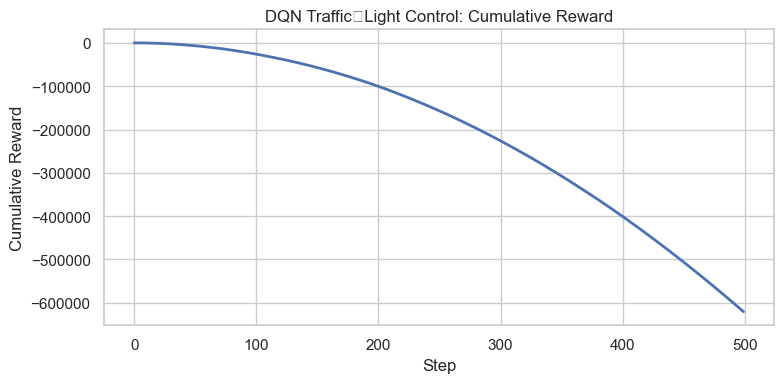

In [15]:
"""
Summary:
- Simulated a 2-phase traffic light system with queues for NS and EW directions.
- Built a Gymnasium-style environment with arrivals (Poisson, λ=5) and departures (10 cars/green).
- Defined reward as negative total queue length; episode ends after 1000 steps.
- Trained a DQN agent (MlpPolicy, Stable-Baselines3) for 10,000 timesteps.
- Evaluated performance via cumulative reward plot across 500 steps.
"""


# ----------------------------
# RL TRAFFIC‐LIGHT CONTROL PROTOTYPE 
# ----------------------------

# 1) Imports
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN

# 2) Define the Gymnasium‐style Traffic Light Environment
class TrafficLightEnv(gym.Env):
    """
    Two‐phase traffic light env using Gymnasium API:
      - reset()   → (obs, info)
      - step()    → (obs, reward, terminated, truncated, info)
    State: [NS_queue, EW_queue]
    Action: 0=NS green, 1=EW green
    Reward: negative total queue length
    """
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Box(0, 100, (2,), dtype=np.float32)
        self.action_space      = spaces.Discrete(2)
        self.max_steps         = 1000

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.ns_queue   = 0
        self.ew_queue   = 0
        self.phase      = 0
        self.step_count = 0
        obs = np.array([0, 0], dtype=np.float32)
        return obs, {}   # obs, info

    def step(self, action):
        # apply phase
        self.phase = action
        # arrivals
        self.ns_queue += np.random.poisson(5)
        self.ew_queue += np.random.poisson(5)
        # departures
        if self.phase == 0:
            self.ns_queue = max(0, self.ns_queue - 10)
        else:
            self.ew_queue = max(0, self.ew_queue - 10)
        # reward & counters
        reward = - (self.ns_queue + self.ew_queue)
        self.step_count += 1
        # end flags
        terminated = False
        truncated  = (self.step_count >= self.max_steps)
        obs = np.array([self.ns_queue, self.ew_queue], dtype=np.float32)
        return obs, reward, terminated, truncated, {}

# 3) Instantiate environment and model
env = TrafficLightEnv()
model = DQN(
    policy='MlpPolicy',
    env=env,
    verbose=1,
    device='cuda'  # or 'cpu' if no GPU
)

# 4) Train the agent
model.learn(total_timesteps=10000)

# 5) Evaluate the trained agent
obs, _ = env.reset()
rewards = []
for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, r, term, trunc, _ = env.step(action)
    rewards.append(r)
    if term or trunc:
        obs, _ = env.reset()

# 6) Plot cumulative reward
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(rewards), linewidth=2)
plt.title('DQN Traffic‐Light Control: Cumulative Reward')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.tight_layout()
plt.show()